# Fruits and Vegetables Classifier

### Importing data and libraries

In [1]:
# Start with the inputs
# We will be using the keras layers API to pick at the layers and to understand which ones we want to use, and which ones we want to retrain

import tensorflow as tf
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Assign directory with training data
train_dir = os.path.join('new_dataset/train-70')

# Directory with testing data
test_dir = os.path.join('new_dataset/test-20')

# Validation directory
validation_dir = os.path.join('new_dataset/validation-10')

print('Training set classes:', len(os.listdir(train_dir)))
print('Testing set size:', len(os.listdir(test_dir)))
print('Validation set size:', len(os.listdir(validation_dir)))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'new_dataset/train-70'

### Transfer learning using InceptionV3 model

In [3]:
# Instantiate the pre-trained model

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150,150,3), #desired input shape for our data
                               include_top = False, #we want to ignore the fully-connected layer at the top, and jump right into the convolutional layers
                               weights = None) #specify we don't want to use the built-in weights but the snapshot we just downloaded

pre_trained_model.load_weights(local_weights_file)

In [4]:
# Iterate through it's layers and lock them

for layer in pre_trained_model.layers:
    layer.trainable = False #so they  will not be trainable with this code
    
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

### Building the new model

In [5]:
# Try using 7x7 layers instead of 3x3 for comparison with clean training

last_layer =  pre_trained_model.get_layer('mixed7')

last_output = last_layer.output

In [6]:
# Then we can define our model, taking the  output from the inception model's mixed7 layer, which we had called as the last output

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output) #flatten the output, which is the last output from the inception
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dense(39, activation='softmax')(x)

model = Model(pre_trained_model.input, x) #create model using the Model abstract class, and fit in model just created
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])


In [7]:
# Data Processing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1/255)

# Flow training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150)
                                                   )     

# Flow validation images in batches of 64 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size = 64,
                                                         class_mode = 'categorical',
                                                         target_size = (150,150)
                                                        )

# Classes to validation set
evaluation_datagen = ImageDataGenerator( rescale = 1/255)
evaluation_set = evaluation_datagen.flow_from_directory(validation_dir,
                                                         class_mode = 'categorical',
                                                         target_size = (150,150)
                                                        )

Found 31887 images belonging to 39 classes.
Found 9112 images belonging to 39 classes.
Found 4551 images belonging to 39 classes.


### Training the model

In [9]:
# Callback to stop the training when targeted accuracy value is met

import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
checkpoint = ModelCheckpoint('best_model_v4.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [10]:
history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              epochs = 100,
                              steps_per_epoch = 100,
                              validation_steps = 50,
                              verbose = 1,
                              callbacks = [early_stop, checkpoint]
                             )

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_21020/4118589479.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.7602 - accuracy: 0.5522
Epoch 1: val_accuracy improved from -inf to 0.73000, saving model to best_model_v4.h5
100/100 [==============================] - 74s 720ms/step - loss: 1.7602 - accuracy: 0.5522 - val_loss: 0.9823 - val_accuracy: 0.7300
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.9655 - accuracy: 0.7277
Epoch 2: val_accuracy improved from 0.73000 to 0.79406, saving model to best_model_v4.h5
100/100 [==============================] - 71s 709ms/step - loss: 0.9655 - accuracy: 0.7277 - val_loss: 0.7039 - val_accuracy: 0.7941
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.8738 - accuracy: 0.7513
Epoch 3: val_accuracy improved from 0.79406 to 0.80937, saving model to best_model_v4.h5
100/100 [==============================] - 72s 717ms/step - loss: 0.8738 - accuracy: 0.7513 - val_loss: 0.6849 - val_accuracy: 0.8094
Epoch 4/100
100/100 [======================

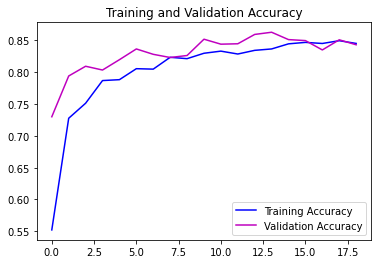

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'm', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### Testing the model

In [11]:
model = tf.keras.models.load_model('best_model_v4.h5')

In [12]:
classmap = train_generator.class_indices
classnames = {v: k for k, v in classmap.items()}
print(classnames)

{0: 'Apple', 1: 'Avocado', 2: 'Banana', 3: 'Bean', 4: 'Bitter Gourd', 5: 'Blueberry', 6: 'Bottle Gourd', 7: 'Brinjal', 8: 'Broccoli', 9: 'Cabbage', 10: 'Capsicum', 11: 'Carrot', 12: 'Cauliflower', 13: 'Coconut', 14: 'Cucumber', 15: 'Dragonfruit', 16: 'Durian', 17: 'Grape', 18: 'Guava', 19: 'Kiwi', 20: 'Lemon', 21: 'Lime', 22: 'Longan', 23: 'Mango', 24: 'Muskmelon', 25: 'Orange', 26: 'Papaya', 27: 'Passion Fruit', 28: 'Pear', 29: 'Pineapple', 30: 'Plumcot', 31: 'Pomegranate', 32: 'Pomelo', 33: 'Potato', 34: 'Pumpkin', 35: 'Radish', 36: 'Strawberry', 37: 'Tomato', 38: 'Watermelon'}


In [13]:
import numpy as np

category={
    0: 'Apple', 1: 'Avocado', 2: 'Banana', 3: 'Bean', 4: 'Bitter Gourd', 5: 'Blueberry', 
    6: 'Bottle Gourd', 7: 'Brinjal', 8: 'Broccoli', 9: 'Cabbage', 10: 'Capsicum', 11: 'Carrot', 
    12: 'Cauliflower', 13: 'Coconut', 14: 'Cucumber', 15: 'Dragonfruit', 16: 'Durian', 17: 'Grape', 
    18: 'Guava', 19: 'Kiwi', 20: 'Lemon', 21: 'Lime', 22: 'Longan', 23: 'Mango', 
    24: 'Muskmelon', 25: 'Orange', 26: 'Papaya', 27: 'Passion Fruit', 28: 'Pear', 29: 'Pineapple', 
    30: 'Plumcot', 31: 'Pomegranate', 32: 'Pomelo', 33: 'Potato', 34: 'Pumpkin', 35: 'Radish', 
    36: 'Strawberry', 37: 'Tomato', 38: 'Watermelon'
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction : {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(150, 150))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

In [17]:
import random
from keras_preprocessing import image

testpath = 'new_dataset/validation-10/'

foldernames = os.listdir(testpath)

counter_right, counter_wrong, counter_unsure = 0,0,0

for foldername in foldernames:
  # print(len(os.listdir(testpath + foldername)), foldername)
  for filename in random.sample(os.listdir(testpath + foldername),2):
    get_any_right = 0

    img = image.load_img(testpath + foldername + '/' + filename, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    
    images = np.vstack([x])
    classes = model.predict(images)
    
    index = np.argmax(classes[0])
    value = classes[0][index]
    
    print(f"{filename:<17} {foldername:>17} : {classnames[index]:<17} {value:>10.10f} ", end='') # {index:>3} 
    if (value<0.9):
        counter_unsure += 1

    if (foldername==classnames[index]):
        counter_right += 1
        get_any_right = 1
        print()
    else:
        counter_wrong += 1
        print("  WRONG")


print(f"Final Score: right {counter_right} : wrong {counter_wrong} : unsure {counter_unsure}, accuracy {counter_right/(counter_right+counter_wrong):.3f}")

1117.jpg                      Apple : Apple             0.7198820710 
1116.jpg                      Apple : Pomegranate       0.3497031629   WRONG
1102.jpg                    Avocado : Passion Fruit     0.3412433863   WRONG
1096.jpg                    Avocado : Avocado           0.4689907134 
1145.jpg                     Banana : Mango             0.5220342278   WRONG
1080.jpg                     Banana : Banana            0.9999995232 
1137.jpg                       Bean : Bean              0.9999986887 
1310.jpg                       Bean : Bean              0.9998198152 
1112.jpg               Bitter Gourd : Bitter Gourd      0.9999611378 
1116.jpg               Bitter Gourd : Bitter Gourd      0.9991164804 
929.jpg                   Blueberry : Blueberry         0.9965369701 
970.jpg                   Blueberry : Blueberry         0.9968898892 
1345.jpg               Bottle Gourd : Bottle Gourd      0.9788159132 
1313.jpg               Bottle Gourd : Bottle Gourd      0.9996943474 

#### Full validation set test for further evaluation

In [19]:
testpath = 'new_dataset/validation-10/'

foldernames = os.listdir(testpath)

counter_right, counter_wrong, counter_unsure = 0,0,0

for foldername in foldernames:
  # print(len(os.listdir(testpath + foldername)), foldername)
  for filename in os.listdir(testpath + foldername):
    get_any_right = 0

    img = image.load_img(testpath + foldername + '/' + filename, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    
    images = np.vstack([x])
    classes = model.predict(images)
    
    index = np.argmax(classes[0])
    value = classes[0][index]
    
    print(f"{filename:<17} {foldername:>17} : {classnames[index]:<17} {value:>10.10f} ", end='') # {index:>3} 
    if (value<0.9):
        counter_unsure += 1

    if (foldername==classnames[index]):
        counter_right += 1
        get_any_right = 1
        print()
    else:
        counter_wrong += 1
        print("  WRONG")


print(f"Final Score: right {counter_right} : wrong {counter_wrong} : unsure {counter_unsure}, accuracy {counter_right/(counter_right+counter_wrong)}")

1083.jpg                      Apple : Apple             0.5314506888 
1084.jpg                      Apple : Apple             0.9994153976 
1085.jpg                      Apple : Apple             0.9999591112 
1086.jpg                      Apple : Apple             0.9432863593 
1087.jpg                      Apple : Guava             0.4745593965   WRONG
1088.jpg                      Apple : Pomelo            0.9519518018   WRONG
1089.jpg                      Apple : Apple             0.9953690171 
1090.jpg                      Apple : Apple             0.9998426437 
1091.jpg                      Apple : Apple             0.9996770620 
1092.jpg                      Apple : Apple             0.9980917573 
1093.jpg                      Apple : Apple             0.9887593985 
1094.jpg                      Apple : Apple             0.9999986887 
1095.jpg                      Apple : Apple             0.9999810457 
1096.jpg                      Apple : Apple             0.6565808058 
1097.j

### Evaluating the Model

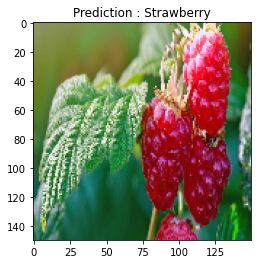

In [39]:
predict_image(os.path.join('test/raspberries-2.jpg'),model)

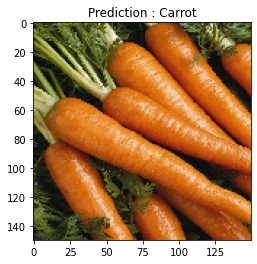

In [45]:
predict_image(os.path.join('test/carrot-1.jpeg'),model)

#### Evaluating using Confusion Matrix

In [ ]:
print('Validation set size:', len(os.listdir(validation_dir)))

from sklearn.metrics import confusion_matrix
import seaborn as sns

def classes_confusion_matrix(validation_dir):
    
    folder_path = validation_dir
    
    mapping = {}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=1
        
    files=[]
    real=[]
    predicted=[]
    
    for i in os.listdir(folder_path):
        
        true = os.path.join(folder_path,i)
        true = true.split('/')[-1]
        true = mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):
            
            img_ = image.load_img(os.path.join(folder_path,i,j),target_size=(150,150))
            img_array = image.img_to_array(img_)
            img_processed = np.expand_dims(img_array,axis=0)
            img_processed /= 255.
            prediction = model.predict(img_processed)
            index = np.argmax(prediction)
            
            predicted.append(index)
            real.append(true)
            
    return (real, predicted)

def print_confusion_matrix(real,predicted):
    total_output_classes = 39
    cmap = 'Blues'
    cm_plot_classes = [i for i in range(39)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_classes,cm_plot_classes)
    sns.set(font_scale=1.2)
    plt.figure(figsize  = (15,10))
    s=sns.heatmap(df_cm,fmt='d',annot=True,cmap=Blues)
    
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.savefig('confusion_matrix.png')
    plt.show()